In [ ]:
! pip install implicit
! pip install transformers

In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import random
import scipy
from implicit import bpr
from collections import defaultdict
from google.colab import files
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

In [ ]:
df = pd.read_csv('data/cleaned_df.csv')

## Baseline (BPR)

In [ ]:
df_selected = df[df['reviewerID'].isin(keep)]

In [ ]:
df_selected = df_selected.sort_values(by='unixReviewTime')

reviewerID        asin  \
135966   A3RTKL9KB8KLID  0393316041   
86870    A3PPXVR5J6U2JD  0312853238   
2563     A3PPXVR5J6U2JD  002907052X   
124178   A3AZ4O4I9S4668  0380723638   
119111   A3CG6YLYZJXQG4  0375402314   
...                 ...         ...   
1084938  A1BUA3LAY7A8ZK  B00I9NSFDO   
1098892   AHR3AU7CPID24  B00LDR38J4   
1098894  A1J4ZZVGTNBQFE  B00LDR38J4   
1080734   A64VNUAXNX8VO  B00HRIDFVY   
1096958  A3FOL8CN5A1TFR  B00KKVNHIQ   

                                                reviewText  overall  \
135966   I was checking on this book because I just rec...      5.0   
86870    Ender's Game is the first (and best) in a seri...      5.0   
2563     There's a lot of angel books out there, all cl...      5.0   
124178   A little slow in a few places but the ending w...      4.0   
119111   As I read this book I was reminded of "Seinfel...      4.0   
...                                                    ...      ...   
1084938  This book was exciting, interesting and naught...      4.0   
1098892  COPY COURTESY OF NETGALLEYFun feel good story....      4.0   
1098894  Addison St. Claire is a matchmaker who helps p...      4.0   
1080734  I have really enjoyed this whole series. Lorel...      5.0   
1096958  A great start to the series by Ms. Rivard. You...      5.0   

                                                   summary unixReviewTime  \
135966                              Absolutely delightful!     1996-09-18   
86870    Xenophobic world creates its greatest leader.....     1996-12-16   
2563     The final word on angels in myth, history, and...     1996-12-17   
124178                                 Pretty Good Mystery     1997-04-29   
119111            Niceness doesn't make compelling reading     1997-07-11   
...                                                    ...            ...   
1084938                                         Quick read     2014-07-23   
1098892                         matchmaker meets her match     2014-07-23   
1098894                         Matchmaker Make Me A Match     2014-07-23   
1080734                                        I loved it.     2014-07-23   
1096958                                 Bound to the Alpha     2014-07-23   

                                                     imUrl  \
135966   http://ecx.images-amazon.com/images/I/51bfXgaj...   
86870    http://ecx.images-amazon.com/images/I/51oXWbP2...   
2563     http://ecx.images-amazon.com/images/I/51pam3AZ...   
124178   http://ecx.images-amazon.com/images/I/51P2MRF1...   
119111   http://ecx.images-amazon.com/images/I/61vWssu8...   
...                                                    ...   
1084938  http://ecx.images-amazon.com/images/I/51QpLkD8...   
1098892  http://ecx.images-amazon.com/images/I/51rmu0H6...   
1098894  http://ecx.images-amazon.com/images/I/51rmu0H6...   
1080734  http://ecx.images-amazon.com/images/I/41m6UEhg...   
1096958  http://ecx.images-amazon.com/images/I/51Yr0hWp...   

                                                     title  price  \
135966   Surely You're Joking, Mr. Feynman! (Adventures...   8.56   
86870                     Ender's Game (The Ender Quintet)   3.99   
2563     A Dictionary of Angels: Including the Fallen A...  12.18   
124178                    Ill Wind (Anna Pigeon Mysteries)   5.99   
119111   Midnight in the Garden of Good and Evil (AUDIO...   8.59   
...                                                    ...    ...   
1084938                                                NaN   6.99   
1098892                                                NaN   0.99   
1098894                                                NaN   0.99   
1080734                                                NaN   5.95   
1096958                                                NaN   2.99   

                                                       cat  unexpectedness  \
135966                                           {'Books'}        0.050864   
86870                               

In [ ]:
itemImgDict = dict(zip(df['asin'], df['imUrl']))
itemNameDict = dict(zip(df['asin'], df['title']))

/usr/local/lib/python3.10/dist-packages/implicit/gpu/__init__.py:13: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: CUDA driver version is insufficient for CUDA runtime version (/project/./implicit/gpu/utils.h:71)'
  warnings.warn(


In [ ]:
interactions = []
ratingDict = {}
for index, d in df.iterrows():
  interactions.append((d['reviewerID'],d['asin'], 1))  #d['overall']
  ratingDict[(d['reviewerID'],d['asin'])] = d['overall']
interactions[0]

('A00473363TJ8YSZ3YAGG9', 'B001Q9EFUK', 1)

In [ ]:
random.shuffle(interactions)
interactionsTrain = interactions[:int(len(interactions)*0.99)]
interactionsValid = interactions[int(len(interactions)*0.99):]
len(interactionsValid)

10992

In [ ]:
userIDs,itemIDs = {},{}
users, items = {}, {}

for u,i,r in interactionsTrain:
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not i in itemIDs: itemIDs[i] = len(itemIDs)

    if not u in users: users[len(users)] = u
    if not i in items: items[len(items)] = i

nUsers,nItems = len(userIDs),len(itemIDs)

In [ ]:
itemsPerUser = defaultdict(list)
usersPerItem = defaultdict(list)

itemsSetPerUser = defaultdict(set)
usersSetPerItem = defaultdict(set)

for u,i,r in interactionsTrain:
    itemsPerUser[u].append(i)
    usersPerItem[i].append(u)

    itemsSetPerUser[u].add(i)
    usersSetPerItem[i].add(u)

allItems = list(usersPerItem.keys())
allUsers = list(itemsPerUser.keys())

In [ ]:
items = list(itemIDs.keys())

In [ ]:
Xui = scipy.sparse.lil_matrix((nUsers, nItems))
for u,i,r in interactionsTrain:
    Xui[userIDs[u],itemIDs[i]] = r

Xui_csr = scipy.sparse.csr_matrix(Xui)

In [ ]:
# Initiate a BPR model with a latent dimension of 100
model = bpr.BayesianPersonalizedRanking(factors = 100)

In [ ]:
model.fit(Xui_csr)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
def print_item_image(item):
    """
    Prints the image of a given item using its URL from a dictionary by calling display.

    :param item: The item name to display the image for.
    
    :display: The image of the specified item.
    """
    try:
        img_url = itemImgDict[item]
        response = requests.get(img_url)

        if response.status_code == 200:
            img_data = BytesIO(response.content)
            img = Image.open(img_data)
            display(img)
        else:
            print(f"Failed to retrieve image. Status code: {response.status_code}")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

In [ ]:


def display_item_images(item_ids, grid_dims=(2, 5)):
    """
    Displays a grid of item images.

    :param item_ids: List of item IDs.
    :param itemImgDict: Dictionary mapping item IDs to image URLs.
    :param itemNameDict: Dictionary mapping item IDs to item titles.
    :param grid_dims: Dimensions of the grid (rows, columns).
    """

    def truncate_title(title, max_length=30):
        """
        Truncates the title if it is too long and adds a newline character for better formatting.

        :param title: The title to truncate.
        :param max_length: Maximum length of the title.

        :return: Truncated title.
        """
        if pd.isnull(title) : return ""
        if len(title) > max_length:
            return title[:max_length] + "...\n" + title[max_length:max_length*2] + ("..." if len(title) > max_length*2 else "")
        return title

    fig, axes = plt.subplots(*grid_dims, figsize=(12, 6))
    axes = axes.flatten()

    for ax, item_id in zip(axes, item_ids):

        if item_id in itemImgDict:
            if pd.isnull(itemImgDict[item_id]):
                ax.set_title(truncate_title(itemNameDict[item_id]))
                ax.axis('off')
                continue
            
            response = requests.get(itemImgDict[item_id])

            img = Image.open(BytesIO(response.content))

            ax.imshow(img)
            ax.axis('off')
            ax.set_title(truncate_title(itemNameDict[item_id]))
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
def recommend(user):
  """
  Recommends items to a user based on their purchase history using a recommendation model.

  :param user: The username for whom recommendations are generated.
  :display: 
  - The user's last 10 purchased items.
  - The top 10 recommended items based on the user's history and the recommendation model.
  """

  print(f"User {user}'s last 10 purchased items: ")
  purchase_history = itemsPerUser[user][-10:]
  display_item_images(purchase_history)

  print("#" * 100)

  print(f"The top 10 recommended items: ")
  recommended = model.recommend(userIDs[user], Xui_csr[userIDs[user]], 10)
  item_ids =  [items[item_id] for item_id in recommended[0]]
  display_item_images(item_ids)

User A3V4CL53QT9X7N's last 10 purchased items: 


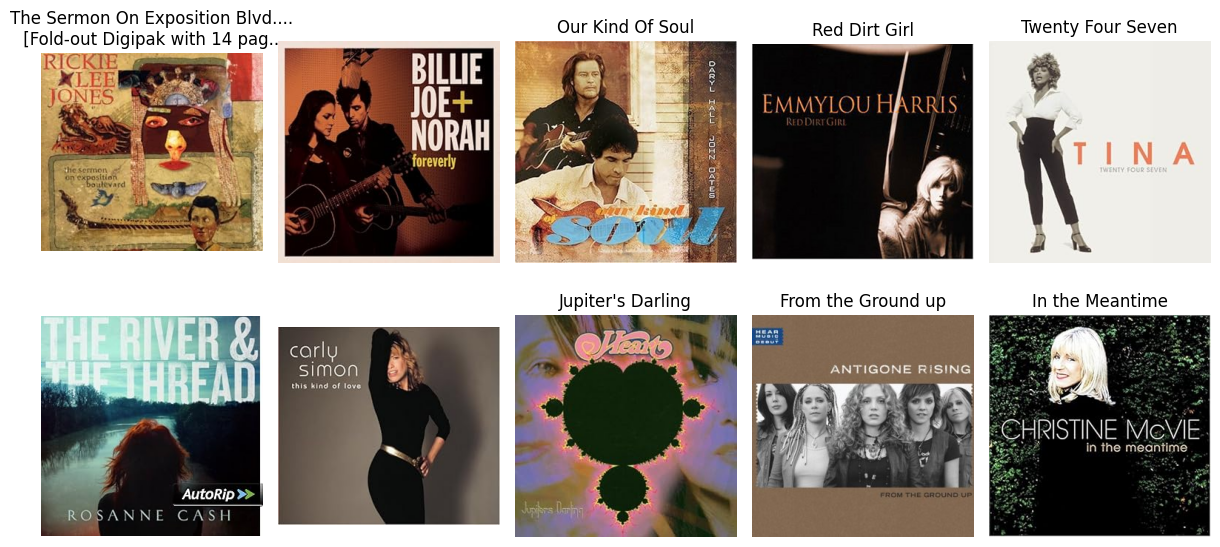

####################################################################################################
The top 10 recommended items: 


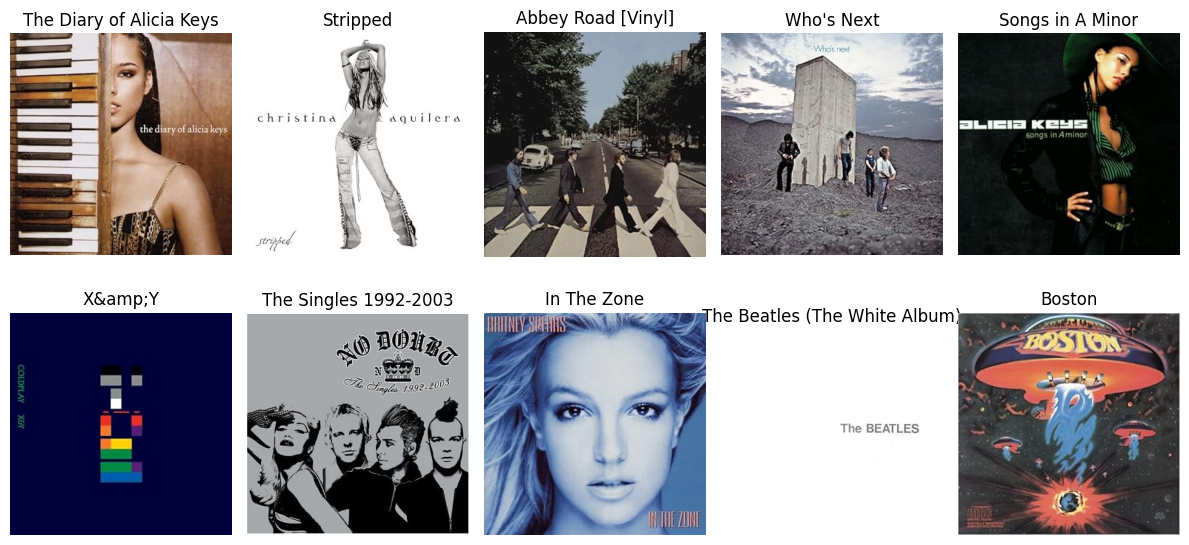

In [ ]:
recommend(users[70])

In [ ]:
recommend(users[10])

Output hidden; open in https://colab.research.google.com to view.

User A3MEMX0XF00TBD's last 10 purchased items: 


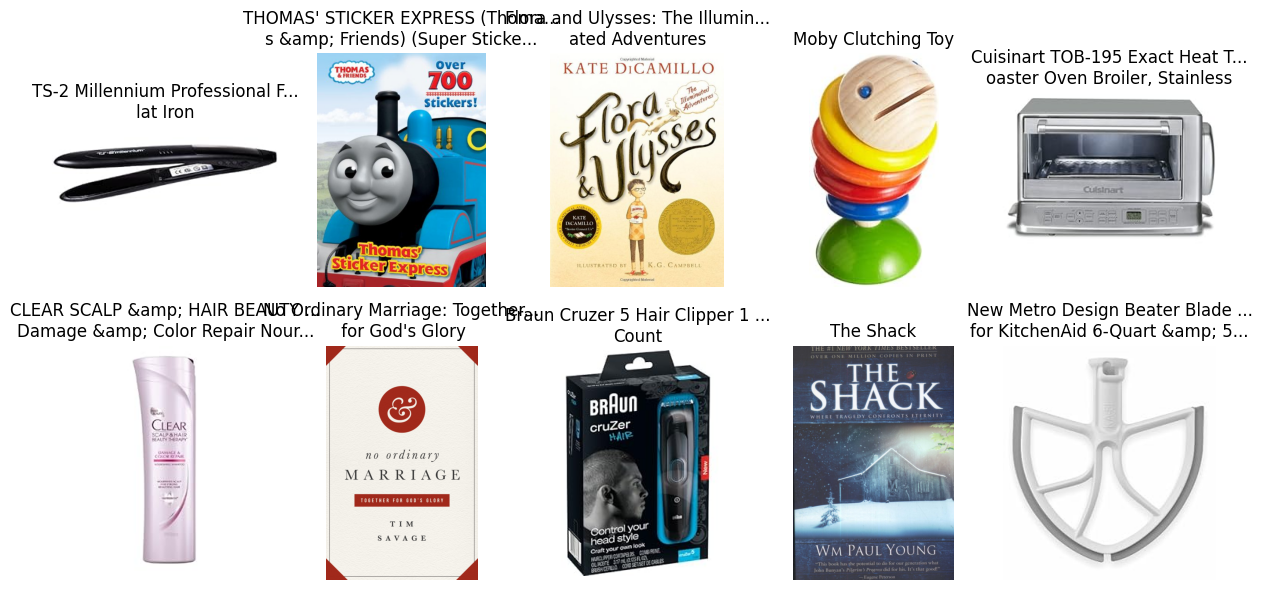

####################################################################################################
The top 10 recommended items: 


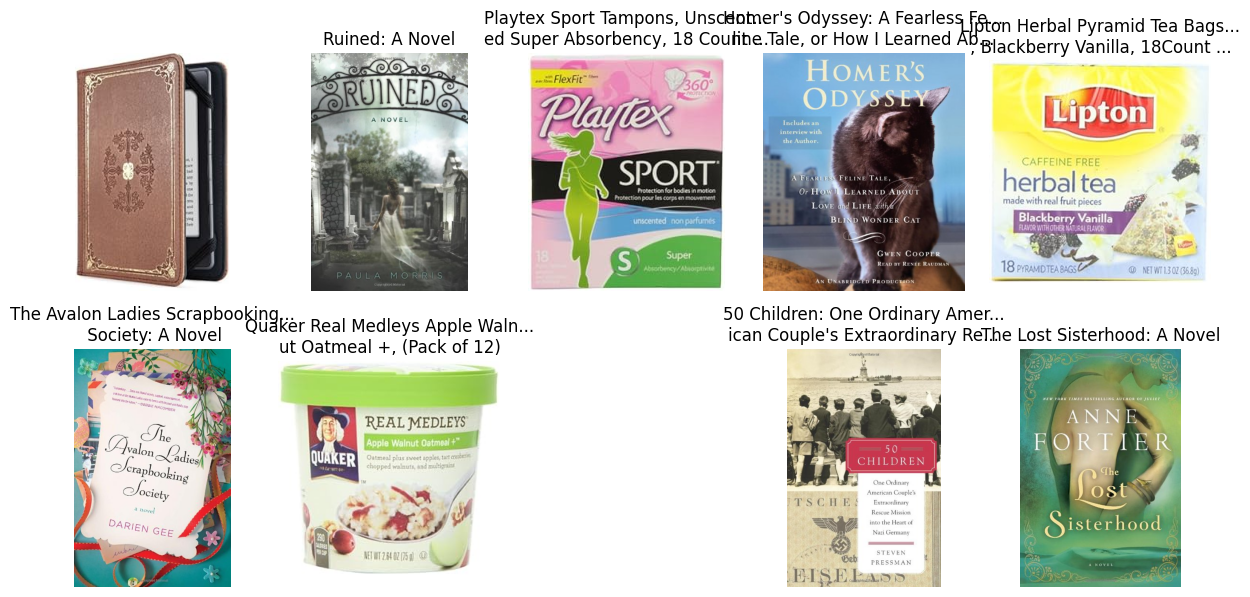

In [ ]:
recommend(users[19780])

In [ ]:
def similar_items(item):
  """
  Finds 10 most similar items to a given item.
  """
  print_item_image(item)

  print(f"10 similar items for {itemNameDict[item]}")

  similar = model.similar_items(itemIDs[item], 11)
  item_ids = [items[item_id] for item_id in similar[0][1:]]
  display_item_images(item_ids)


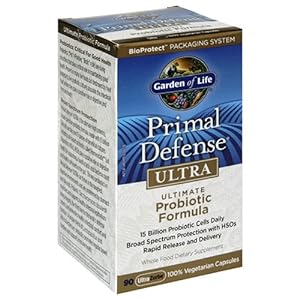

10 similar items for Garden of Life Primal Defense Ultra Ultimate Probiotic Formula, 90 Capsules


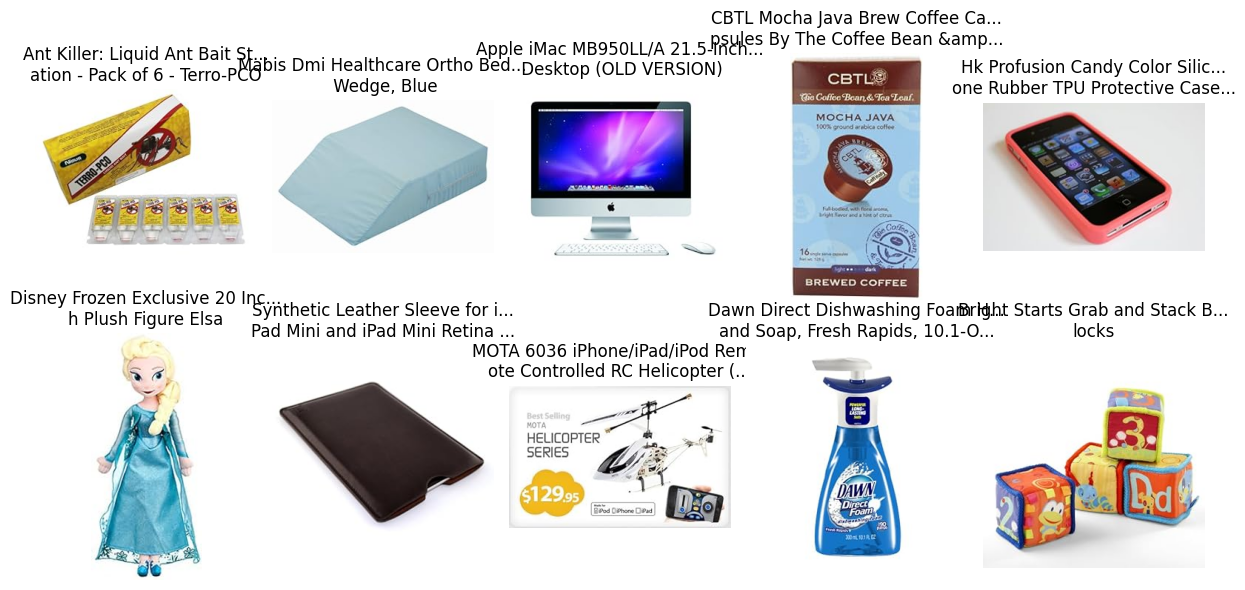

In [ ]:
similar_items(items[164560])